In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sigproc_kit import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def U_parallel_RC(t,I,R,C):
    # calculate time evolution of parallel RC circuit
    # discrete solution of the differential equation
    
    # time step
    dt = t[1]-t[0]
    
    U = np.zeros(len(t))
    last_U = 0
    
    for i in range(len(t)):   
        U[i] = 1/(1/R+C/dt) * ( I[i] + C/dt*last_U) 
        last_U = U[i]
    
    return U

In [3]:
t = np.arange(0,100e-9,10e-12) # time goes from 0 to 100 ns in steps of 10 ps


In [4]:
def scint_PMT_sig(t,N_phot,tau_scint,C_det):

    photon_signal = np.zeros(len(t))
    
    
    #N_phot = 200 # number of photons produced in the scintillator due to radiation
    
    # Scintillator gets excited. Excitation decays according to an exponential distribution
    
    #tau_scint = 5e-9 # scintillator decay time, here 5 ns
    
    photon_toa = np.random.exponential(tau_scint,N_phot) # draw from an exponential random number generator
    
    photon_toa += 10e-9 # signal comes after 10 ns, just an offset
    
    
    dt = t[1]-t[0]
    # fill a histogram
    for toa in photon_toa:
        index = int(toa/dt)
        photon_signal[index] += 1
        
        
        
    R = 50      # the input impedance of the oscilloscope
    #C = 100e-12 # realistic guess on anode capacitance of a medium sized PMT
    C = C_det
    
    PMT_gain = 1e6 # guess
    Qe = 1.602e-19 # electron charge
    
    # each photon makes Qe * PMT_gain of electrical charge
    I_signal = photon_signal * Qe * PMT_gain / dt
    
    
    V_open = integrate_dt(t,I_signal)/C
    
    
    V_signal = U_parallel_RC(t,I_signal,R,C)
    
    
    
    
    scope_BW = 500e6 # let's say you have 500 MHz analog BW 
    
    scope_signal = RC_filter(t,V_signal,1,1/(2*np.pi*scope_BW))
    
    return scope_signal
    

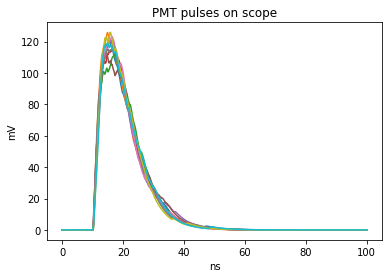

In [5]:
N_phot = 200
tau_scint = 5e-9
C_det = 100e-12

for i in range(10):
    scope_signal = scint_PMT_sig(t,N_phot,tau_scint,C_det)
    plt.plot(t*1e9,scope_signal*1e3)
    
plt.xlabel("ns")
plt.title("PMT pulses on scope")
plt.ylabel("mV")
plt.show()

In [6]:
# find the minimum of the CF shaped pulse, cut off everything before the minimum
# then discriminate at the baseline - you will find the zero crossing

def CFD(t,y,fraction,delay):
    shaped = CF_shaper(t,y,fraction,delay)
    index = np.argmin(shaped)
    return discriminate(t[index:],shaped[index:],0)

In [7]:
def CSaunders_shaper(t,y,tau,fraction):
    lpf = RC_filter(t,y,1,tau)
    return lpf - fraction*y

def CS_CFD(t,y,tau,fraction):
    shaped = CSaunders_shaper(t,y,tau,fraction)
    index = np.argmin(shaped)
    return discriminate(t[index:],shaped[index:],0)

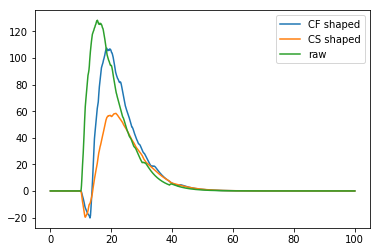

In [8]:
example_pulse = scint_PMT_sig(t,N_phot,tau_scint,C_det)

CFD_fraction = 0.2
CFD_delay    = 3e-9

CF_shaped_pulse = CF_shaper(t,example_pulse,CFD_fraction,CFD_delay)

CR_shaped_pulse = CR_filter(t,example_pulse,50,100e-12)

CS_tau = 3e-9
#CS_fraction = 0.5 # not so nice
CS_fraction = 0.5
CS_shaped_pulse = CSaunders_shaper(t,example_pulse,CS_tau,CS_fraction)

plt.plot(t*1e9,CF_shaped_pulse*1e3,label="CF shaped")
#plt.plot(t*1e9,CR_shaped_pulse*1e3,label="CR shaped")
plt.plot(t*1e9,CS_shaped_pulse*1e3,label="CS shaped")
plt.plot(t*1e9,example_pulse*1e3,label="raw")
plt.legend()

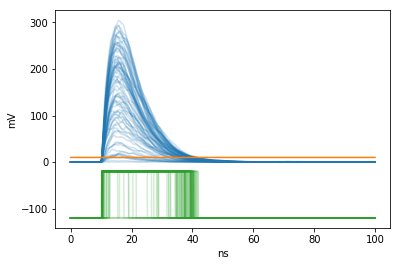

In [9]:
t1_list  = np.array([])
tot_list = np.array([])

amp_list = np.array([])

t1_CFD =  np.array([])
t1_CS_CFD = np.array([])

thresh = 10e-3

N_phot_max = 500

for i in range(0,1000):

  N_phot = int(np.random.random()*N_phot_max)

  y = scint_PMT_sig(t,N_phot,tau_scint,C_det)
  discr, t1, tot = discriminate(t,y,thresh)
  t1_list  = np.append(t1_list,[t1])
  tot_list = np.append(tot_list,[tot])
  amp_list = np.append(amp_list,[np.max(y)])

  if (i < 80):
    alpha = 0.2
    plt.plot(t*1e9,y*1e3,label="det pulse",color=colors[0],alpha=alpha)
    plt.plot(t*1e9,discr*100-120,label="discr. out",color=colors[2],alpha=alpha)
    
  discr, t1, tot = CFD(t,y,CFD_fraction,CFD_delay) 
  t1_CFD = np.append(t1_CFD,[t1])
    
  discr, t1, tot = CS_CFD(t,y,CS_tau,CS_fraction) 
  t1_CS_CFD = np.append(t1_CS_CFD,[t1])
    
plt.plot(t*1e9,y*0+thresh*1e3,label="threshold",color=colors[1])
plt.xlabel("ns")
plt.ylabel("mV")
plt.show()
    

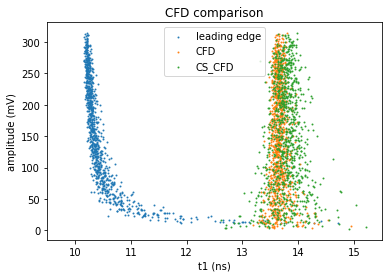

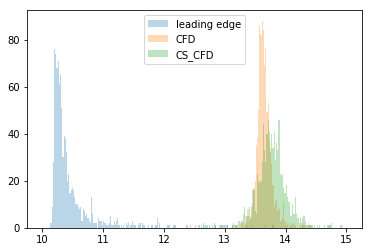

In [13]:
plt.scatter(t1_list*1e9,amp_list*1e3, s=1, alpha=0.9,label="leading edge")
plt.xlabel("t1 (ns)")
plt.ylabel("amplitude (mV)")
plt.title("CFD comparison")

plt.scatter(t1_CFD*1e9,amp_list*1e3, s=1, alpha=0.9,label="CFD")

plt.scatter(t1_CS_CFD*1e9,amp_list*1e3, s=1, alpha=0.9,label="CS_CFD")

plt.xlim(9.5,15.5)
plt.legend()


plt.show()

bins = np.linspace(10,15,256)

plt.hist(t1_list*1e9,bins=bins,label="leading edge",alpha=0.3)
plt.hist(t1_CFD*1e9,bins=bins,label="CFD",alpha=0.3)
plt.hist(t1_CS_CFD*1e9,bins=bins,label="CS_CFD",alpha=0.3)
plt.legend()

plt.show()
